<a href="https://colab.research.google.com/github/RehanAfzalkhan/HW-3-Deep-Learning-and-its-Applications-Neural-Networks/blob/main/CSI_5140_HW_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
# ================Detailes of given task=============================
# HW #3 - K-means on MNIST (CSI 4140/5140)
# Muhammad Rehan Afzal
# Notes:
#   - Unsupervised K-means on MNIST train set (no labels)
#   - Show centroids as 28x28 images for k in {2, 5, 20, 30}
#   - Provide brief comparison comments vs PCA (from HW#2)
# =========================================================

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil, sqrt
from tqdm import tqdm

In [3]:
# We'll use torchvision to load MNIST easily (works well on Colab)


In [4]:
import torch
import torchvision
from torchvision import transforms

In [5]:
# KMeans from scikit-learn


In [6]:
from sklearn.cluster import KMeans


In [7]:
# Make results reproducible


In [8]:
np.random.seed(42)
torch.manual_seed(42)

In [9]:
# ----- 1) Load MNIST (train set only) -----
# We only need images (no labels) because K-means is UNSUPERVISED.

# Transform: convert PIL image -> Tensor in [0,1]
to_tensor = transforms.ToTensor()

mnist_train = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=to_tensor
)

# Stack all training images into a single array of shape (N, 1, 28, 28)
# Then flatten to (N, 784) and keep dtype float32 in [0,1]
imgs = torch.stack([mnist_train[i][0] for i in range(len(mnist_train))])  # (60000, 1, 28, 28)
X = imgs.view(len(mnist_train), -1).numpy().astype(np.float32)            # (60000, 784)

print("MNIST train loaded:")
print("X shape:", X.shape, "range:", (X.min(), X.max()))


100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.59MB/s]


MNIST train loaded:
X shape: (60000, 784) range: (np.float32(0.0), np.float32(1.0))


In [10]:
# ----- 2) Utility: grid display function for centroid images -----
def show_centroids_grid(centroids, k, title="Centroids"):
    """
    centroids: (k, 784) array of centroid vectors in [0,1]
    k        : number of centroids
    """
    # Compute rows/cols for a nice grid
    cols = int(ceil(sqrt(k)))
    rows = int(ceil(k / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(1.8*cols, 1.8*rows))
    axes = np.array(axes).reshape(rows, cols)

    for idx in range(rows*cols):
        ax = axes[idx // cols, idx % cols]
        ax.axis("off")
        if idx < k:
            img = centroids[idx].reshape(28, 28)
            ax.imshow(img, cmap="gray", vmin=0, vmax=1)
            ax.set_title(f"c{idx+1}", fontsize=9)
    fig.suptitle(f"{title} (k={k})", fontsize=12)
    plt.tight_layout()
    plt.show()



[Running KMeans for k=2]
Centroids shape: (2, 784)


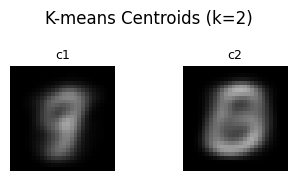


[Running KMeans for k=5]
Centroids shape: (5, 784)


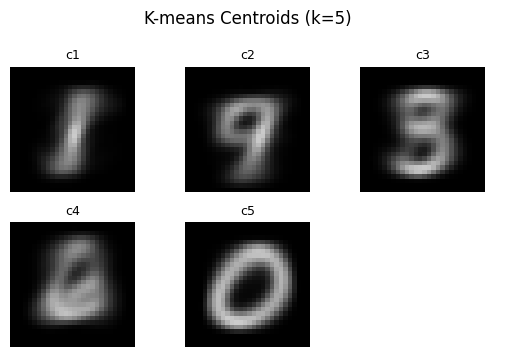


[Running KMeans for k=20]
Centroids shape: (20, 784)


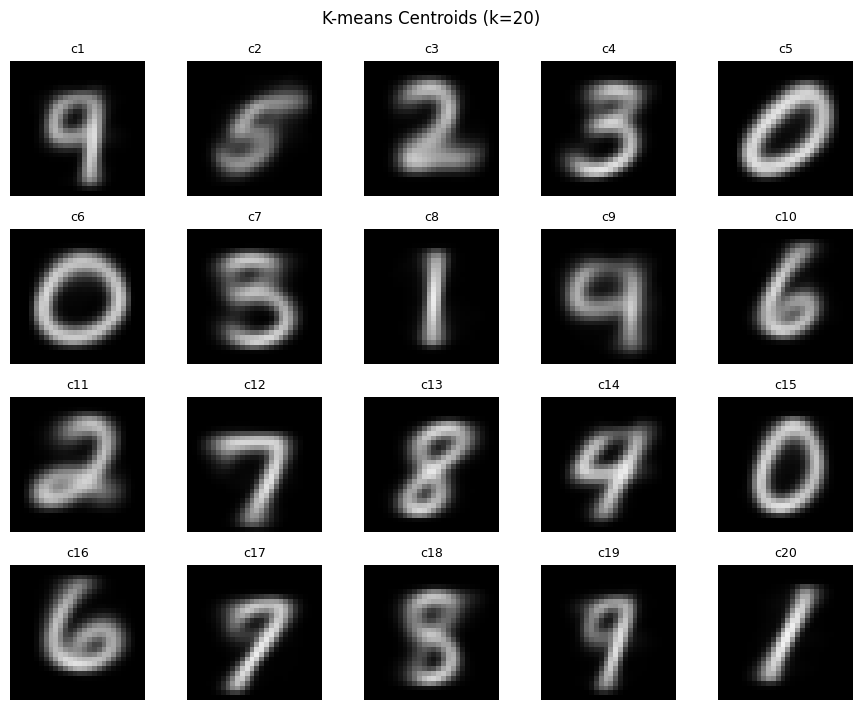


[Running KMeans for k=30]
Centroids shape: (30, 784)


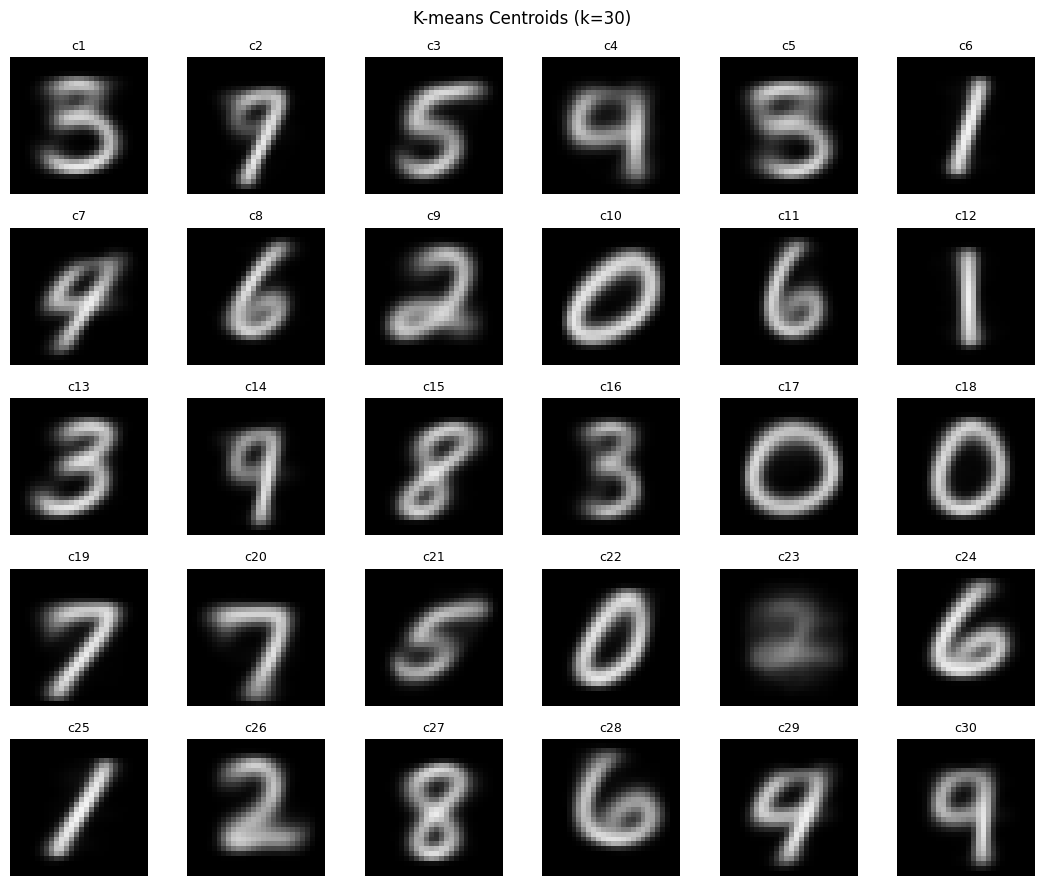

In [11]:
# ----- 3) Run K-means for k in {2, 5, 20, 30} -----
# Notes:
# - We use Euclidean distance (default in KMeans).
# - init='k-means++' provides a stable and good initialization.
# - n_init=10 is enough for this assignment on Colab free tier.

ks = [2, 5, 20, 30]
centroids_by_k = {}

for k in ks:
    print(f"\n[Running KMeans for k={k}]")
    kmeans = KMeans(
        n_clusters=k,
        init="k-means++",
        n_init=10,
        max_iter=300,
        random_state=42,
        verbose=0
    )
    # Fit on all 60k training images (flattened)
    kmeans.fit(X)  # labels_ are UNSUPERVISED assignments, not digit labels

    # Centroids are the "average digits" for each cluster
    centroids = kmeans.cluster_centers_.astype(np.float32)

    # Clip to [0,1] just in case of tiny numeric drift (usually not needed)
    centroids = np.clip(centroids, 0.0, 1.0)

    centroids_by_k[k] = centroids
    print(f"Centroids shape: {centroids.shape}")

    # Visualize centroids as 28x28 images in a grid
    show_centroids_grid(centroids, k, title="K-means Centroids")


In [12]:
# ----- 4) (Required) Short Discussion Helper -----
# This is a ready-to-edit text block you can paste into your report.
# Edit it briefly with your own observations after looking at the plots.

discussion = r"""
HW#3 – K-means on MNIST (Discussion)

K-means is an unsupervised, distance-based clustering method. I ran K-means on the MNIST training set (60,000 images),
ignoring labels, and obtained centroid images for k ∈ {2, 5, 20, 30}. Each centroid is a 784-D mean vector of the cluster,
reshaped to 28×28 for visualization.

Observations by k:
- k=2: The centroids are very coarse averages of broad digit families (e.g., one centroid looks like round/closed digits such as 0/6/8/9,
  and the other looks like elongated digits such as 1/7). The images are blurry because many different digits are averaged together.
- k=5: Centroids start separating into more specific groups; shapes look more digit-like. Some clusters capture vertical strokes (1/7),
  while others capture round shapes (0/6/8/9), and some show mixed curves (2/3/5).
- k=20: Centroids become clearer “average digits” and even capture different writing styles (e.g., slanted 2, open-top 4, curly 9).
- k=30: Centroids look sharper and more diverse; clusters represent finer sub-styles within the same digit (e.g., different ways of writing 3 or 7).

Comparison with PCA (from HW#2):
- PCA eigenvectors (components) are orthogonal “directions of variation” in the data; visually they look like ghost-like strokes
  showing how pixel intensities tend to change together. They are not meant to look like digits by themselves.
- K-means centroids are prototype images (means of clusters). They look like actual “average digits” because they are computed by averaging real samples.
- Conceptually, PCA explains variance globally with a linear basis, while K-means describes local structure by grouping similar samples.
- As k increases, K-means centroids become more specific and interpretable as typical digit styles, whereas PCA components remain abstract basis vectors.

Conclusion:
K-means on MNIST produces intuitive, interpretable “average digit” prototypes. Increasing k yields centroids that are sharper and more specific.
This complements PCA: PCA provides global variance directions, while K-means provides local prototype representatives of the data.
"""

print(discussion)



HW#3 – K-means on MNIST (Discussion)

K-means is an unsupervised, distance-based clustering method. I ran K-means on the MNIST training set (60,000 images),
ignoring labels, and obtained centroid images for k ∈ {2, 5, 20, 30}. Each centroid is a 784-D mean vector of the cluster,
reshaped to 28×28 for visualization.

Observations by k:
- k=2: The centroids are very coarse averages of broad digit families (e.g., one centroid looks like round/closed digits such as 0/6/8/9,
  and the other looks like elongated digits such as 1/7). The images are blurry because many different digits are averaged together.
- k=5: Centroids start separating into more specific groups; shapes look more digit-like. Some clusters capture vertical strokes (1/7),
  while others capture round shapes (0/6/8/9), and some show mixed curves (2/3/5).
- k=20: Centroids become clearer “average digits” and even capture different writing styles (e.g., slanted 2, open-top 4, curly 9).
- k=30: Centroids look sharper and more 